# Продвинутое машинное обучение: ДЗ 1

## Часть I: О теореме Байеса

### Задание 1

Введём два события:  
- A - человек виновен в убийстве  
- B - у человека данная группа крови  
  
Тогда по теореме Байеса:

$$P(A|B) = P(B|A) * P(A) / P(B),$$  

- P(A|B) - вероятность, что человек виновен при условии, что у него данная группа крови
- P(B|A) - вероятность, что у человека данная группа крови при условии, что он убийца
- P(A) - априорная вероятность виновности человека в убийстве (процент убийц среди всего человечества)
- P(B) - априорная вероятность присутствия данной группы крови у человека (0.01)

$$P(B) = P(B|A) * P(A) + P(B|/A) * P(/A) = 0.01$$

- где /A - человек не виновен в убийстве
- Прокурор должен был оценить `P(A|B)` по формуле выше.
- На практике прокурор оценил `P(B|/A) = 0.01`, в этом и ошибся

### Задание 2

Вероятно, адвокат принял:
- P(A) = 1% - априорная вероятность виновности человека в убийстве
- P(B) = 1% - априорная вероятность присутствия данной группы крови у человека  
  
Далее адвокат сделал допущение о независимости этих случайных событий (что не верно) и решил, что
$$P(A|B) = P(A) * P(B) = 0.01\% $$  
  
- Адвокат должен был следовать формуле, приведённой в задании 1:
$$P(A|B) = P(B|A) * P(A) / P(B),$$  

### Задание 3

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

figsize = (15,8)
legend_fontsize = 16

%matplotlib inline

Апостериорная вероятность после положительного теста: 0.161017, P(false positive)=0.05
Апостериорная вероятность после отрицательного теста: 0.000531, P(false negative)=0.05


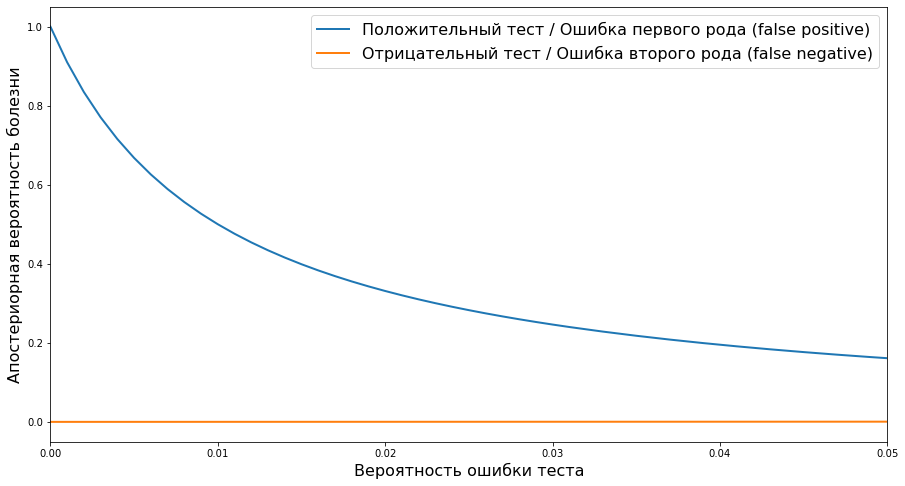

In [2]:
## если data = 1, тест положительный
def compute_posterior(data, prior_prob=0.01, test_fault_p=0.05, test_fault_n=0.05):
    if data == 1:
        return (prior_prob * (1-test_fault_p)) / (prior_prob * (1-test_fault_p) + (1-prior_prob) * test_fault_p)
    elif data == 0:
        return (prior_prob * test_fault_n) / (prior_prob * test_fault_n + (1-prior_prob) * (1-test_fault_n))
    else:
        return None

print("Апостериорная вероятность после положительного теста: {:.6f}, P(false positive)=0.05".format(compute_posterior(1)) )
print("Апостериорная вероятность после отрицательного теста: {:.6f}, P(false negative)=0.05".format(compute_posterior(0)) )

vector_posterior_fp = np.vectorize(compute_posterior, excluded=['data', 'prior_prob', 'test_fault_n'])
xs = np.arange(0, 0.5, 0.001)
ys_one_fp = vector_posterior_fp(1, test_fault_p=xs)

vector_posterior_fn = np.vectorize(compute_posterior, excluded=['data', 'prior_prob', 'test_fault_p'])
ys_zero_fn = vector_posterior_fn(0, test_fault_n=xs)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, ys_one_fp, linewidth=2, label='Положительный тест / Ошибка первого рода (false positive)')
ax.plot(xs, ys_zero_fn, linewidth=2, label='Отрицательный тест / Ошибка второго рода (false negative)')
ax.set_xlim((0.0, 0.05))
ax.set_ylabel('Апостериорная вероятность болезни', fontsize=legend_fontsize)
ax.set_xlabel('Вероятность ошибки теста', fontsize=legend_fontsize)
ax.legend(fontsize=legend_fontsize)
# fig.savefig('intro1.pdf', bbox_inches='tight')
plt.show()

- Выгоднее уменьшать ошибку первого рода (ошибки при положительном тесте).

## Часть II: О линейной регрессии

### Задание 1

- Загрузим данные, выделим тренировочную и тестовую выборки

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [4]:
data = pd.read_csv('owid-covid-data.csv')
data.head(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
5,AFG,Asia,Afghanistan,2020-02-29,1.0,0.0,0.143,NaN,NaN,0.0,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
6,AFG,Asia,Afghanistan,2020-03-01,1.0,0.0,0.143,NaN,NaN,0.0,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
7,AFG,Asia,Afghanistan,2020-03-02,1.0,0.0,0.000,NaN,NaN,0.0,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
8,AFG,Asia,Afghanistan,2020-03-03,2.0,1.0,0.143,NaN,NaN,0.0,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
9,AFG,Asia,Afghanistan,2020-03-04,4.0,2.0,0.429,NaN,NaN,0.0,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [5]:
START_DATE = '2020-03-03'
data = data.loc[(data['iso_code'] == 'RUS') & (data['date'] >= START_DATE)].reset_index(drop=True)
data.shape

(347, 59)

In [6]:
data['date'] = data['date'].astype('datetime64')
data['total_cases'] = data['total_cases'].astype('int64')
data['new_cases'] = data['new_cases'].astype('int64')

In [7]:
data.loc[data['new_cases'] == 0, 'new_cases'] = 1

In [8]:
# создадим целевой признак y=ln(total_cases) и регрессор x - номер дня измерения (от 2020-03-03)
data['y'] = np.log(data['total_cases'])
data['x'] = (data['date'] - pd.Timestamp(START_DATE)) // np.timedelta64(1, 'D')

In [9]:
train = data.iloc[:50]
train.shape

(50, 61)

In [10]:
test = data.iloc[50:]
test.shape

(297, 61)

### Задание 2

- Попстрои графики целевых переменных

<AxesSubplot:title={'center':'New cases over date. Train data'}, xlabel='date', ylabel='new_cases'>

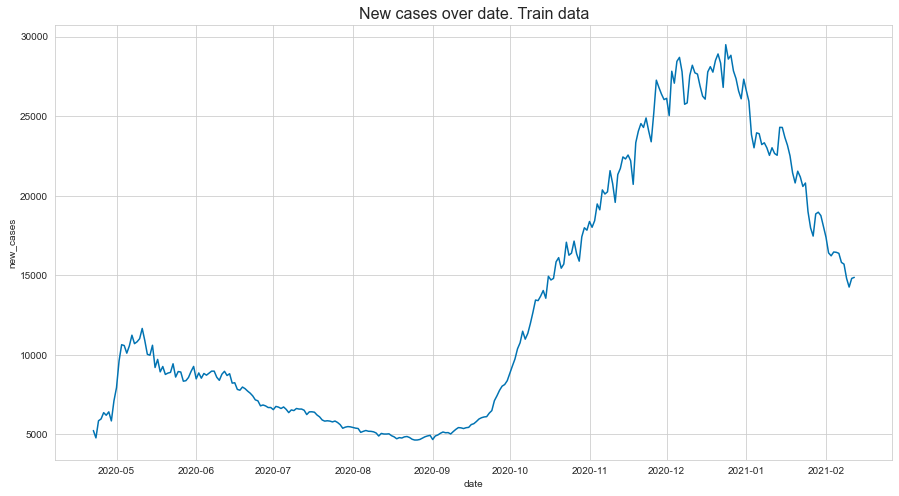

In [11]:
fig = plt.figure(figsize=figsize)
fig.add_subplot(111)
plt.title('New cases over date. Train data', fontsize=legend_fontsize)
sns.lineplot(x='date', y='new_cases', data=test)

<AxesSubplot:title={'center':'Total cases over date. Train data'}, xlabel='date', ylabel='total_cases'>

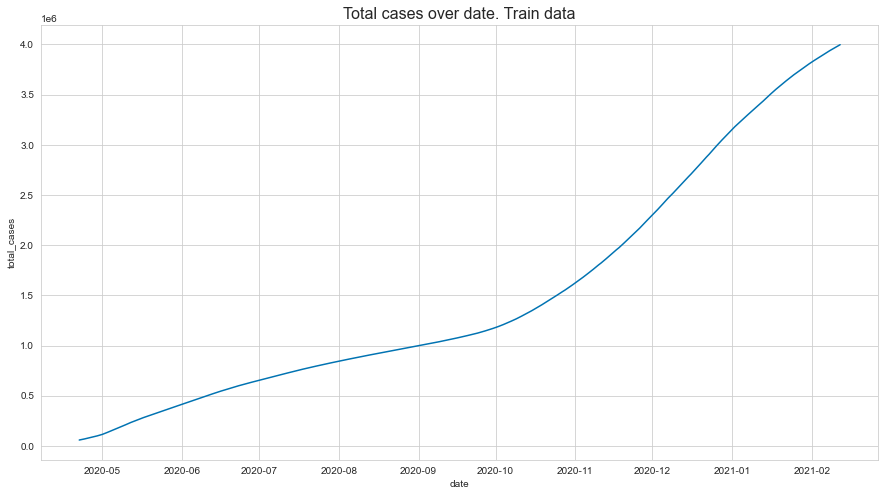

In [12]:
fig = plt.figure(figsize=figsize)
fig.add_subplot(111)
plt.title('Total cases over date. Train data', fontsize=legend_fontsize)
sns.lineplot(x='date', y='total_cases', data=test)

- Обучим линейную регрессию вида:  
$$ln(y) = w1 * x + w0$$
где y - total_cases, x - номер текущего дня

In [13]:
model = LinearRegression()
model.fit(train[['x']], train.y)
ln_pred = model.predict(test[['x']])
tot_pred = np.exp(ln_pred)

In [14]:
model.coef_

array([0.19829091])

- Найдём выборочную дисперсию имеющихся данных вокруг предсказанного значения

In [15]:
sigma_ml = (1/len(train) * sum((train.y - model.predict(train[['x']]))**2)) ** .5
sigma_ml

0.34904220596356583

- Найдём апостериорное распределение параметров модели.

In [16]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_ml):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [17]:
mu, sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
for i in range(len(train)):
    mu, sigma = bayesian_update(mu, sigma, train.x[i], train.y[i])

- Посэмплируем экспоненты

In [18]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [19]:
print('Исходя из экспоненциальной модели, количество заболевших:')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    preds = np.exp(sample_statistics(mu, sigma, test.loc[test['date'] == date, 'x'], n=200))
    print(f'На момент {date}: {np.around(np.mean(preds))}')

Исходя из экспоненциальной модели, количество заболевших:
На момент 2020-05-01: 754682.0
На момент 2020-06-01: 355379533.0
На момент 2020-09-01: 3.2941063204571684e+16


- Построим графики получившихся экспонент

In [20]:
def sample_exps(mu, sigma, xlim, ylim, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(14, 8))
    for w in my_w:
        plt.plot(test.date, np.exp(w[0] + w[1]*test.x), 'k-', lw=.4)
    
    plt.ylim(ylim)
    plt.xlim(xlim)

Предсказания на момент 1 мая:


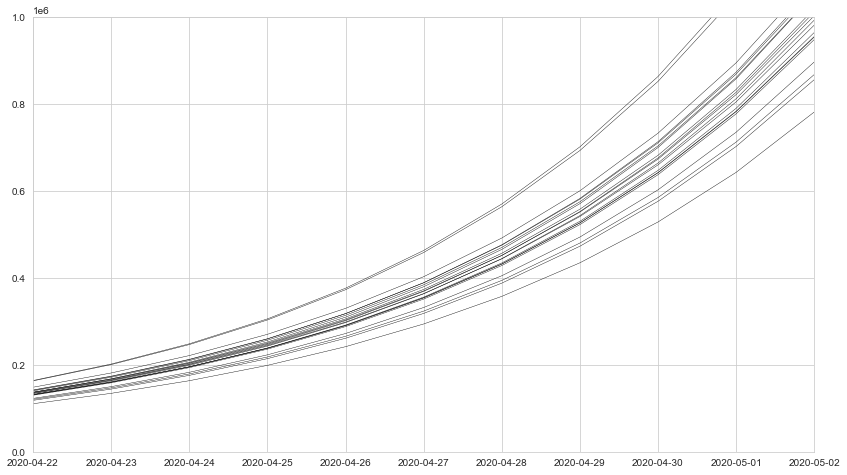

In [21]:
print('Предсказания на момент 1 мая:')
sample_exps(mu, sigma, xlim=(dt.date(2020, 4, 22), dt.date(2020, 5, 2)), ylim=(0, 10**6))

Предсказания на момент 1 июня:


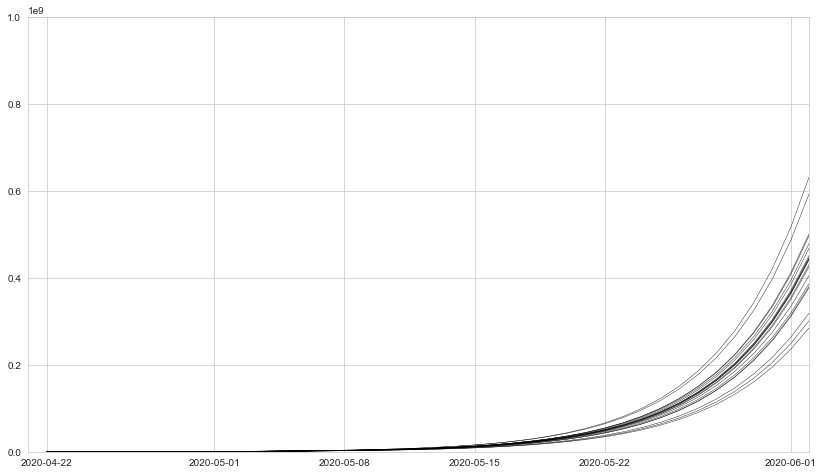

In [22]:
print('Предсказания на момент 1 июня:')
sample_exps(mu, sigma, xlim=(dt.date(2020, 4, 21), dt.date(2020, 6, 2)), ylim=(0, 10**9))

Предсказания на момент 1 сентября:


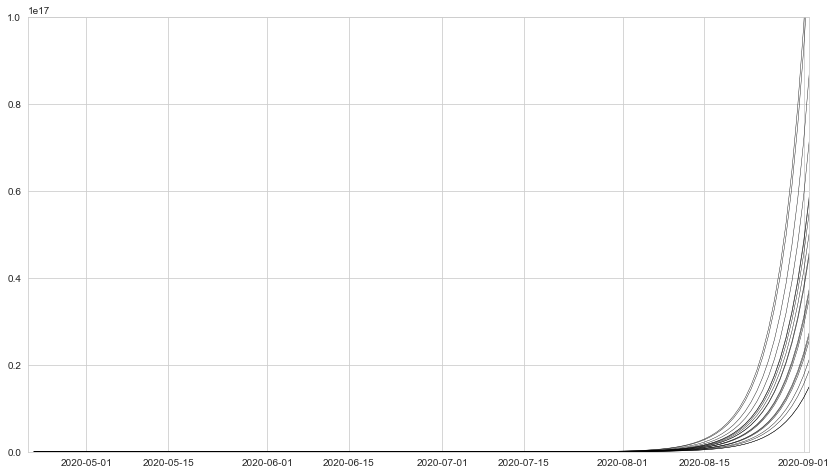

In [23]:
print('Предсказания на момент 1 сентября:')
sample_exps(mu, sigma, xlim=(dt.date(2020, 4, 21), dt.date(2020, 9, 2)), ylim=(0, 10**17))

- Предсказания, основанные на экспоненциальной модели, не отражают реальность.

### Задание 3

- Возьмём форму функции распределения Гауссиана для моделирования роста числа заболевших:

<tex>$$total\_cases = \int_{-\infty}^x e^{w_2t^2+w_1t+w_0}dt$$</tex>

- Обучать параметры сигмоидальной функции с помощью линейной регрессии не удобно.
- Вместо этого рассмотрим в качестве целевого признака `new_cases`
<tex>$$new\_cases = \frac{d(total\_cases)}{d(t)} = e^{w_2t^2+w_1t+w_0}$$</tex>  
- Возьмём натуральный логарифм от обеих частей выражения:
<tex>$$\ln(new\_cases) = w_2t^2+w_1t+w_0$$</tex>  
- В таком виде обучим параметры линейной модели. Для этого добавим t^2 в качестве дополнительного параметра (квадрат количества дней с начала заражения)

In [24]:
train.loc[:, 'x_2'] = train.loc[:, 'x'] ** 2
test.loc[:, 'x_2'] = test.loc[:, 'x'] ** 2

C:\Users\defaultuser0\miniconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\defaultuser0\miniconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [25]:
train.loc[:, 'ln_new'] = np.log(train.loc[:, 'new_cases'])
test.loc[:, 'ln_new'] = np.log(test.loc[:, 'new_cases'])

In [26]:
model = LinearRegression()
model.fit(train[['x', 'x_2']], train.ln_new)
ln_new_pred = model.predict(test[['x', 'x_2']])
new_pred = np.exp(ln_new_pred)

In [27]:
model.coef_

array([ 0.27562283, -0.00182979])

- Найдём выборочную дисперсию имеющихся данных вокруг предсказанного значения

In [28]:
sigma_ml = (1/len(train) * sum((train.ln_new - model.predict(train[['x', 'x_2']]))**2)) ** .5
sigma_ml

0.48916954245951955

- Найдём апостериорное распределение параметров модели.

In [29]:
def bayesian_update(mu, sigma, x, x_2, y, sigma_noise=sigma_ml):
    x_matrix = np.array([[1, x, x_2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [30]:
mu, sigma = np.array([0, 0, 0]), 2*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
for i in range(len(train)):
    mu, sigma = bayesian_update(mu, sigma, train.x[i], train.x_2[i], train.ln_new[i], sigma_ml)

In [31]:
mu

array([-0.3884184 ,  0.27494955, -0.00181835])

- Посэмплируем экспоненты

In [32]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((xs.shape[0], n))
    for i,w in enumerate(my_w):
        res[:,i] = w[0] + w[1]*xs['x'] + w[2]*xs['x_2']
    return res

In [33]:
new_cases_samps = pd.DataFrame(sample_statistics(mu, sigma, test.loc[:, ['x', 'x_2']], n=200), index=test.index)
# new_cases_samps[new_cases_samps < 0] = 0
tot_cases_samps = np.cumsum(np.exp(new_cases_samps), axis=0)
tot_cases_samps['date'] = test['date']

In [34]:
print('Исходя из модели, основанной на распределении гауссиана, среднее предсказание на количество заболевших:')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    preds = np.mean(tot_cases_samps.loc[tot_cases_samps['date'] == date, tot_cases_samps.columns != 'date'], axis=1).values
    print(f'На момент {date}: {np.around(preds[0])}')

Исходя из модели, основанной на распределении гауссиана, среднее предсказание на количество заболевших:
На момент 2020-05-01: 108038.0
На момент 2020-06-01: 1353021.0
На момент 2020-09-01: 284148849.0


- Построим графики получившихся распределений общего числа заболевших

In [35]:
def sample_gaus(xlim, ylim, n=20, points=None):
    plt.figure(figsize=(14, 8))
    for i in range(n):
        plt.plot(tot_cases_samps.date, tot_cases_samps[i], 'k-', lw=.4)
    plt.ylim(ylim)
    plt.xlim(xlim)

Предсказания на момент 1 мая:


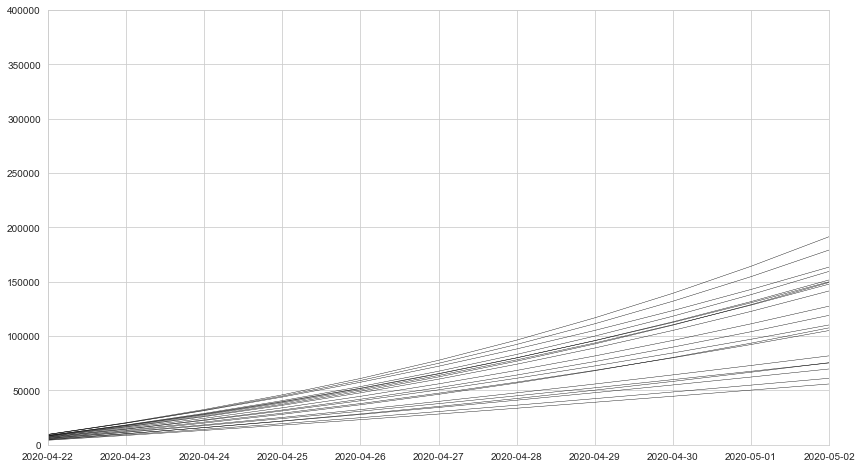

In [36]:
print('Предсказания на момент 1 мая:')
sample_gaus(xlim=(dt.date(2020, 4, 22), dt.date(2020, 5, 2)), ylim=(0, 4*10**5))

Предсказания на момент 1 июня:


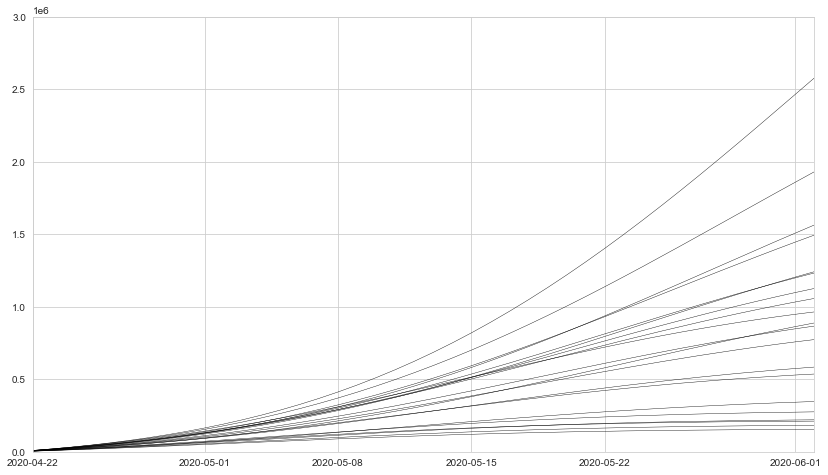

In [37]:
print('Предсказания на момент 1 июня:')
sample_gaus(xlim=(dt.date(2020, 4, 22), dt.date(2020, 6, 2)), ylim=(0, 3*10**6))

Предсказания на момент 1 сентября:


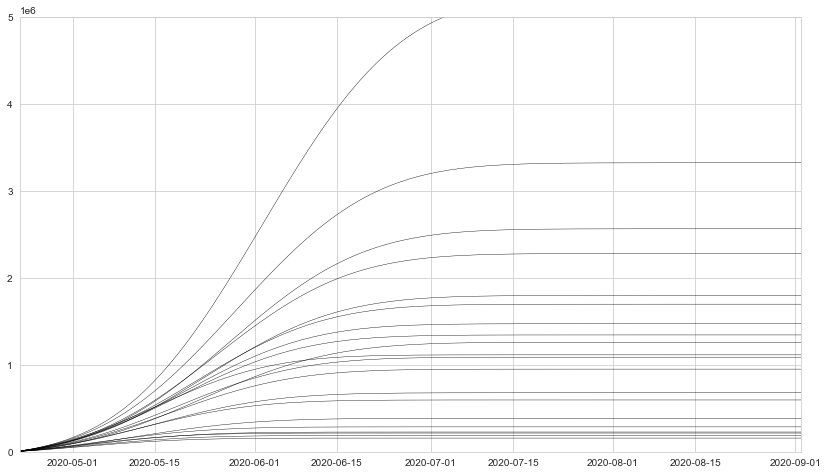

In [38]:
print('Предсказания на момент 1 сентября:')
sample_gaus(xlim=(dt.date(2020, 4, 22), dt.date(2020, 9, 2)), ylim=(0, 5*10**6))

- Прогнозы числа случаев коронавируса в оптимистичном и пессимистичном сценариях:

In [39]:
print('Пессимистичный прогноз (90-й процентиль):')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    preds = np.percentile(tot_cases_samps.loc[tot_cases_samps['date'] == date, tot_cases_samps.columns != 'date'], 90, axis=1)
    print(f'На момент {date}: {np.around(preds[0])}')

Пессимистичный прогноз (90-й процентиль):
На момент 2020-05-01: 155618.0
На момент 2020-06-01: 2473549.0
На момент 2020-09-01: 5853388.0


In [40]:
print('Пессимистичный прогноз (10-й процентиль):')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    preds = np.percentile(tot_cases_samps.loc[tot_cases_samps['date'] == date, tot_cases_samps.columns != 'date'], 10, axis=1)
    print(f'На момент {date}: {np.around(preds[0])}')

Пессимистичный прогноз (10-й процентиль):
На момент 2020-05-01: 65630.0
На момент 2020-06-01: 262169.0
На момент 2020-09-01: 275852.0


In [41]:
print('Фактическое количество случаев:')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    fact = test.loc[test['date'] == date, 'total_cases'].values
    print(f'На момент {date}: {fact[0]}')

Фактическое количество случаев:
На момент 2020-05-01: 114431
На момент 2020-06-01: 414328
На момент 2020-09-01: 997072


### Задание 4

- Построим модели и найдём распределения их параметров для других стран.

In [42]:
df = pd.read_csv('owid-covid-data.csv')
df = df.loc[(~df['new_cases'].isna()) & (df['iso_code'] != 'FSM')]

In [43]:
iso_codes = df.loc[~df['continent'].isna(), 'iso_code'].unique()

In [44]:
def get_train_test(iso_code):
    """
    функция выделяет данные по одной стране (iso_code),
    создаёт признаки: количество дней с первого случая и квадрат количества дней,
    целевой признак ln_new - натуральный логарифм от количества случаев за день (new_cases).
    функция возвращает train и test подвыборки
    """
    df_iso = df.loc[(df['iso_code'] == iso_code) & ~df['new_cases'].isna()].reset_index(drop=True)
    df_iso['date'] = df_iso['date'].astype('datetime64')
    df_iso['total_cases'] = df_iso['total_cases'].astype('int64')
    df_iso['new_cases'] = df_iso['new_cases'].astype('int64')
    df_iso.loc[df_iso['new_cases'] < 1, 'new_cases'] = 1
    
    start_date = df_iso.loc[0, 'date']
    df_iso['ln_new'] = np.log(df_iso['new_cases'])
    df_iso['x'] = (df_iso['date'] - pd.Timestamp(start_date)) // np.timedelta64(1, 'D')
    df_iso['x_2'] = df_iso['x'] ** 2
    
    train_size=len(df_iso)//2
    train = df_iso.iloc[:train_size]
    test = df_iso.iloc[train_size:]
    return train, test

In [45]:
def train_model(train):
    """
    функция обучает модель линейной регрессии 
        ln_new = w0 + w1*x + w2*x_2
    и оценивает дисперсию шума в данных.
    """
    model = LinearRegression()
    model.fit(train[['x', 'x_2']], train.ln_new)
    ln_new_pred = model.predict(test[['x', 'x_2']])
    new_pred = np.exp(ln_new_pred)
    
    sigma_ml = (1/len(train) * sum((train.ln_new - model.predict(train[['x', 'x_2']]))**2)) ** .5
    sigma_ml = max(sigma_ml, 0.001)
    return model, sigma_ml

In [46]:
def find_params_distr(train, sigma_ml):
    """
    функция определяет распределение N(mu, sigma^2) параметров линейной регрессии
    """
    mu, sigma = np.array([0, 0, 0]), 2*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    for i in range(len(train)):
        mu, sigma = bayesian_update(mu, sigma, train.x[i], train.x_2[i], train.ln_new[i], sigma_ml)
    return mu, sigma

- Для каждой страны обучим модель линейной регрессии  
    `ln_new = w0 + w1*x + w2*x_2`
- Проведём оценку распределений N(mu, sigma^2) параметров обученной модели

In [47]:
mu_list = []
sigma_list = []
for iso_code in iso_codes:
    train, test = get_train_test(iso_code)
    model, sigma_ml = train_model(train)
    coefs = model.coef_
    mu, sigma = find_params_distr(train, sigma_ml)
    mu_list.append(mu)
    sigma_list.append(sigma)

In [48]:
params_df = pd.DataFrame(mu_list, columns = ['w0', 'w1', 'w2'])
params_df['iso_codes'] = iso_codes
print('Математические ожидания параметров моделей по странам:')
params_df.head(10)

Математические ожидания параметров моделей по странам:


,w0,w1,w2,iso_codes
0,-1.260449,0.137992,-0.000645,AFG
1,2.039757,0.006433,0.000082,ALB
2,0.851336,0.073909,-0.000260,DZA
3,2.025441,-0.028097,0.000129,AND
4,-0.120902,0.006485,0.000138,AGO
5,0.128326,-0.000346,0.000002,ATG
6,1.082187,0.082585,-0.000217,ARG
7,0.321649,0.101618,-0.000441,ARM
8,0.718155,0.028754,-0.000032,AUS
9,4.032581,-0.001442,0.000029,AUT


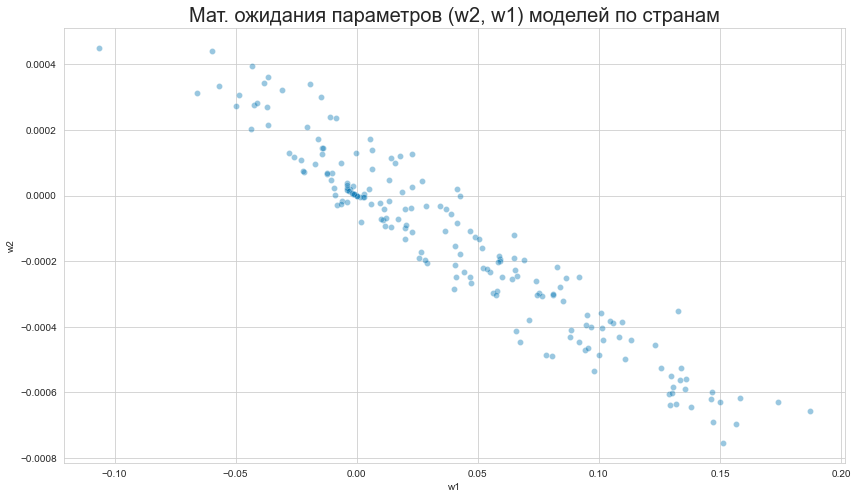

In [49]:
plt.figure(figsize=(14, 8))
plt.title("Мат. ожидания параметров (w2, w1) моделей по странам", fontsize=20)
sns.scatterplot(data=params_df, x='w1', y='w2', alpha=0.4)
plt.show()

- Сложно разделить страны на кластеры по параметрам модели. Однако есть много стран с практически нулевыми коэффициентами (причиной этому может служить недостаток данных)
- Наблюдается линейная зависимость между мат. ожиданиями параметров при линейном и квадратичном членах. Чем больше линейный коэффициент w1, тем меньше квадратичный w2.
- Наблюдается много стран с положительным параметром w2 при квадратичном члене. Это говорит о положительной степени при экспоненте в функции распределения для гауссиана при `x->inf`. В таком виде функция не ограничена сверху (total_cases стремится к бесконечности), и модель не является репрезентативной на большом промежутке времени. Однако, для многих таких моделей параметр w1 отрицательный и на 2-3 порядка больше по модулю, чем w2.  
Значит, на рассматриваемом отрезке времени (x < 400 дней) степень при экспоненте `w0 + w1*x + w2*x_2` убывает и становится меньше нуля, => ежедневный прирост новых случаев уменьшается. Это отражает реальные данные на исследуемом промежутке времени, при достижении критического числа заболевших, их ежедневный прирост сокращается.
- Также наблюдается несколько стран с положительными параметрами w0, w1, w2. Эти модели не ограничены сверху и не отражают реальные данные. Возможно, стоит накопить больше данных для обучения таких моделей.

### Задание 5

- Ежедневное количество случаев заражения неплохо описывается экспоненциальной моделью `y = exp(w0 + w1*x + w2*x^2)`. Сначала рост заболевших резко увеличивается, затем происходит насыщение и рост ежедневных случаев (new_cases) уменьшается.
- Если рост количества зараженных происходит слишком быстро, в стране появляется много больных одновременно, система здравоохранения не может с этим справиться и в этот момент появляется много жертв.
- Карантин необходим для сглаживания кривой ежедневного прироста заболевших. 
- Для принятия решения о вводе карантина можно взять производную d(new_cases)/dt (или каким-то образом её оценить). Если она больше нуля, то процесс заражения выходит из под контроля, и необходимо вводить карантин.